In [18]:
# Import The Libraries
import pandas as pd, matplotlib.pyplot as plt, numpy as np, seaborn as sns, scipy as sp, warnings
warnings.filterwarnings("ignore")
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans,MiniBatchKMeans
from wordcloud import WordCloud
sns.set_style("whitegrid")
from keras.layers import Dense,Input
from keras.models import Sequential, Model

In [3]:
dataset=pd.read_excel('C:/Personal/NUIG/Project-DA/online_retail_II.xlsx',sheet_name=None)
Data_Clean = dataset['Year 2009-2010'].append(dataset['Year 2010-2011'],ignore_index=True)
#remove all customers with NA customer ID
Data_Clean = Data_Clean[Data_Clean['Customer ID'].notna()]
#remove the negative quantity values and duplicate transactions
data = Data_Clean[(Data_Clean['Price'] > 0) & (Data_Clean['Quantity']>0)]
data.drop_duplicates(inplace = True)
data['Final_Price'] = data['Price'] * data['Quantity']

In [4]:
descriptions=data['Description'].apply(str).unique()
print(descriptions.shape)

(5283,)


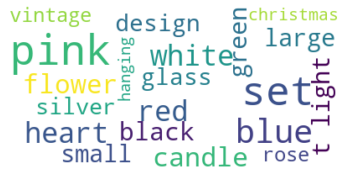

In [5]:
text=[t.lower() for t in descriptions]
text=' '.join([word for word in text])
wordcloud = WordCloud(max_font_size=50, max_words=20, background_color="white",stopwords=ENGLISH_STOP_WORDS).generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [8]:
stop_words =['flower','rose','candle','heart','small', 'large','light','black', 'red', 'blue', 'green', 'white',  'pink','glass', 'silver','set','vintage','design','hanging',
                  'of','in','s','f','t']


### Using TfidfVectorizer

Apply TfidfVectorizer on descriptions.

In [9]:
vectorizer = TfidfVectorizer(stop_words=stop_words)
X_tfidf = vectorizer.fit_transform(descriptions) 

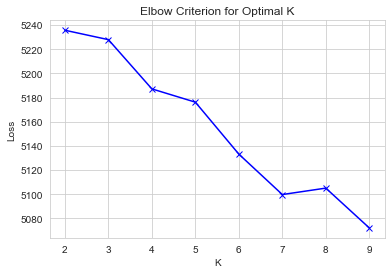

In [11]:
#Use elbow criterion for determining number of category clusters.

Sum_of_squared_distances = []
K = range(2,10)
for k in K:
    km = MiniBatchKMeans(n_clusters=k, max_iter=4000, n_init=500, random_state=1000) #used insetead KMeans(n_clusters=k, max_iter=4000, n_init=500, random_state=1000, n_jobs= -1) for speed improvement
    km = km.fit(X_tfidf)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('K')
plt.ylabel('Loss')
plt.title('Elbow Criterion for Optimal K')
plt.show()

4    4613
1     290
5     117
3     105
0      81
2      77
Name: category, dtype: int64
Category: 0


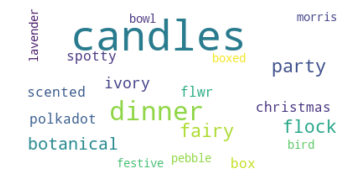

Category: 1


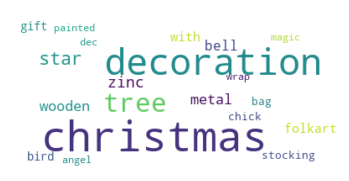

Category: 2


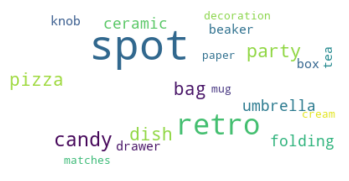

Category: 3


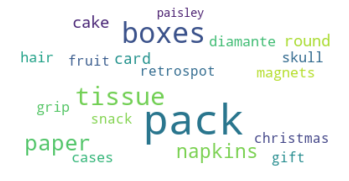

Category: 4


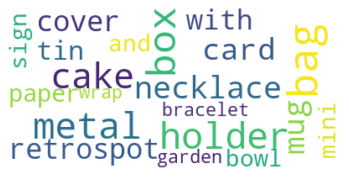

Category: 5


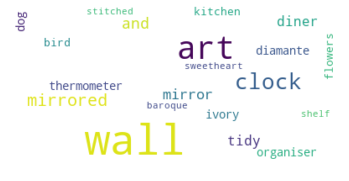

In [12]:
# set number of clusters
true_k = 6
# perform k-means clustering 
model = MiniBatchKMeans(n_clusters=true_k, init='k-means++', max_iter=4000, n_init=500, random_state=1000)
model.fit(X_tfidf)
# get cluster assignment for each item set
labels=model.labels_
tfidf_description_category=pd.DataFrame(list(zip(descriptions,labels)),columns=['Description','category'])
# print number of items per cluster
print(tfidf_description_category['category'].value_counts())

# create wordclouds for each cluster
for k in range(0,true_k):
    s=tfidf_description_category[tfidf_description_category.category==k]
    text=s['Description'].str.cat(sep=' ')
    text=text.lower()
    text=' '.join([word for word in text.split()])
    wordcloud = WordCloud(max_font_size=50, max_words=20, background_color="white",stopwords=custom_stopwords,collocations=False).generate(text)
    print('Category: {}'.format(k))
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [13]:
or_cate= pd.merge(data,tfidf_description_category,on='Description',how='inner')
or_cate.head()
#grouping on the basis of price for each category
cust_level_data=or_cate.pivot_table(index=["Customer ID"], 
                    columns='category', 
                    values='Final_Price',
                    aggfunc='sum').reset_index()
cust_level_data=cust_level_data.fillna(0)
cust_level_data.head()

category,Customer ID,0,1,2,3,4,5
0,12346.0,0.0,14.98,7.49,0.0,77533.99,0.0
1,12347.0,15.3,47.60,0.00,92.4,4745.83,20.4
2,12348.0,0.0,94.20,0.00,466.8,1458.40,0.0
3,12349.0,0.0,10.20,45.45,60.6,4292.54,19.9
4,12350.0,0.0,0.00,0.00,0.0,334.40,0.0


In [14]:
cust_level_data['total']=abs(cust_level_data[0])+abs(cust_level_data[1])+abs(cust_level_data[2])+abs(cust_level_data[3])+abs(cust_level_data[4])+abs(cust_level_data[5])
cust_level_data.loc[cust_level_data['total']==0,'total']=1
cust_level_data[0]=abs(cust_level_data[0])/cust_level_data['total']
cust_level_data[1]=abs(cust_level_data[1])/cust_level_data['total']
cust_level_data[2]=abs(cust_level_data[2])/cust_level_data['total']
cust_level_data[3]=abs(cust_level_data[3])/cust_level_data['total']
cust_level_data[4]=abs(cust_level_data[4])/cust_level_data['total']
cust_level_data[5]=abs(cust_level_data[5])/cust_level_data['total']
cust_level_data=cust_level_data.drop(['total'],axis=1)
cust_level_data.fillna(0)
cust_level_data.to_pickle('desc_cat_final.pkl') 

## Model 1 : Using the above categories as an input with RFM values for clustering.

In [16]:
#read prod category and rfm data
prod_cat = pd.read_pickle('category_clusters_6_Cat_4clus.pickle')
rfm = pd.read_pickle('rfm.pkl')

In [17]:
final_data = pd.merge(prod_cat,rfm,on='Customer ID')
final_data_new = pd.merge(prod_cat,rfm,on='Customer ID')
final_data.drop(['RFM_Segment','Customer ID','R','F','M','cluster','RFM_Score'],axis = 'columns',inplace=True)
final_data.rename(columns={0:'0',1:'1',2:'2',3:'3',4:'4',5:'5'})

#Rescaling
from sklearn.preprocessing import MinMaxScaler
numeric_columns = final_data.columns.values.tolist()
scaler = MinMaxScaler() 
final_data[numeric_columns] = scaler.fit_transform(final_data[numeric_columns])

In [23]:
final_data.head()

,0,1,2,3,4,5,Frequency,Recency,Monetary_value
0,0.000000,0.000193,0.000097,0.000000,0.999710,0.000000,0.002654,0.440379,0.076693
1,0.003109,0.009672,0.000000,0.018775,0.964300,0.005551,0.017774,0.001355,0.007268
2,0.000000,0.046648,0.000000,0.231158,0.722195,0.000000,0.004021,0.100271,0.004760
3,0.000000,0.002303,0.010263,0.013684,0.969257,0.006018,0.013994,0.024390,0.013109
4,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.001287,0.418699,0.003935


In [24]:
input_df = Input( shape = (9, ))
x = Dense(7, activation = 'relu')(input_df)
x = Dense(500, activation = 'relu', kernel_initializer='glorot_uniform')(x)
x = Dense(500, activation = 'relu', kernel_initializer='glorot_uniform')(x)
x = Dense(2000, activation = 'relu', kernel_initializer='glorot_uniform')(x)
encoded = Dense(2, activation = 'relu', kernel_initializer='glorot_uniform')(x)
x = Dense(2000, activation = 'relu', kernel_initializer='glorot_uniform')(encoded)
x = Dense(500, activation = 'relu', kernel_initializer='glorot_uniform')(x)
decoded = Dense(9, kernel_initializer='glorot_uniform')(x)
autoencoder = Model(input_df, decoded)
encoder = Model(input_df, encoded)
autoencoder.compile(optimizer = 'adam', loss = 'mean_squared_error')
autoencoder.fit(final_data, final_data, batch_size= 120, epochs = 25, verbose = 1)
pred = encoder.predict(final_data )

Epoch 1/25
49/49 [==============================] - 2s 26ms/step - loss: 0.0443
Epoch 2/25
49/49 [==============================] - 1s 21ms/step - loss: 0.0031
Epoch 3/25
49/49 [==============================] - 1s 22ms/step - loss: 0.0015
Epoch 4/25
49/49 [==============================] - 1s 23ms/step - loss: 0.0014
Epoch 5/25
49/49 [==============================] - 1s 22ms/step - loss: 0.0012
Epoch 6/25
49/49 [==============================] - 1s 21ms/step - loss: 0.0011
Epoch 7/25
49/49 [==============================] - 1s 22ms/step - loss: 0.0010
Epoch 8/25
49/49 [==============================] - 1s 22ms/step - loss: 0.0011
Epoch 9/25
49/49 [==============================] - 1s 20ms/step - loss: 0.0012
Epoch 10/25
49/49 [==============================] - 1s 20ms/step - loss: 0.0011
Epoch 11/25
49/49 [==============================] - 1s 20ms/step - loss: 9.4953e-04
Epoch 12/25
49/49 [==============================] - 1s 20ms/step - loss: 9.4874e-04
Epoch 13/25
49/49 [==========

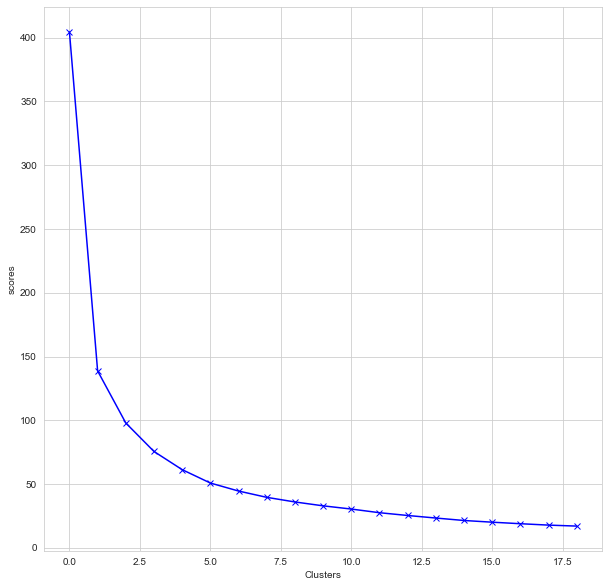

In [25]:
from sklearn.cluster import KMeans
scores_2 = []

range_values = range(1, 20)

for i in range_values:
    
    kmeans = KMeans(n_clusters= i)
    kmeans.fit(pred)
    scores_2.append(kmeans.inertia_)
plt.figure(figsize=(10,10))
plt.plot(scores_2, 'bx-')
plt.xlabel('Clusters')
plt.ylabel('scores') 
kmeans = KMeans(3)
kmeans.fit(pred)
labels = kmeans.labels_
y_kmeans = kmeans.fit_predict(final_data)

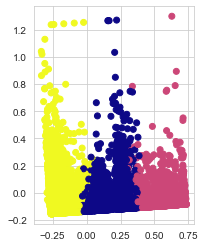

In [26]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
prin_comp = pca.fit_transform(final_data)
import matplotlib.pyplot as plt
plt.scatter(prin_comp[:,0],prin_comp[:,1],c=labels,cmap="plasma")

#fig = plt.figure()
ax = plt.gca()
ax.set_aspect(1) 

In [27]:
from sklearn.metrics import silhouette_samples,silhouette_score
df_cluster_dr = pd.concat([final_data_new, pd.DataFrame({'cluster_final':labels})], axis = 1)
df_cluster_dr.head()
print(df_cluster_dr['cluster_final'].value_counts())
silhouette_avg = silhouette_score(final_data, y_kmeans)
print('score de silhouette: {:<.3f}'.format(silhouette_avg))

2    3476
0    1608
1     794
Name: cluster_final, dtype: int64
score de silhouette: 0.530


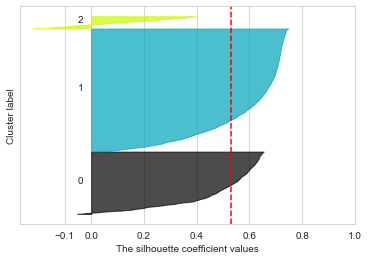

In [29]:
from matplotlib import cm
# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(final_data, y_kmeans)
fig, (ax1) = plt.subplots(1, 1)
y_lower = 10
for i in range(3):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
    ith_cluster_silhouette_values = \
        sample_silhouette_values[y_kmeans == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / 3)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

#ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()

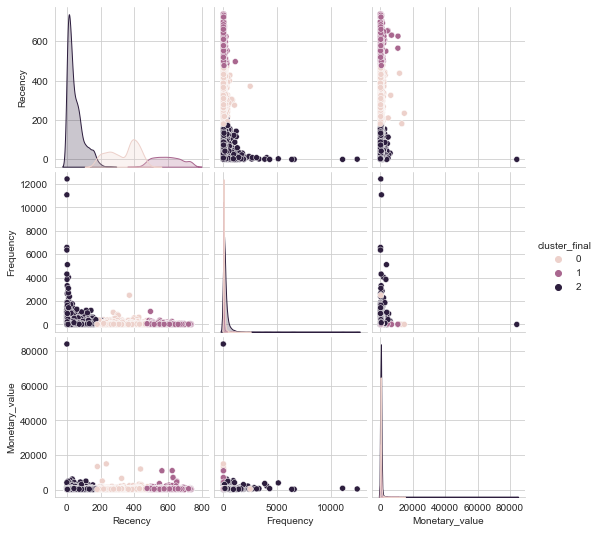

In [30]:
df_clus = df_cluster_dr[['Recency','Frequency','Monetary_value','cluster_final']]

import seaborn as sns
sns.pairplot(df_clus, hue = 'cluster_final')

In [ ]:
df_cluster_dr.to_csv('3_clusters_M1.csv')